In [1]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [2]:
%cd "C:/Users/tanzi/OneDrive/0.1 Project/food-101/food-101"

C:\Users\tanzi\OneDrive\0.1 Project\food-101\food-101


In [3]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.10.1
/device:GPU:0


In [4]:
os.listdir('food-101/images')

['.DS_Store',
 'apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisq

In [5]:
os.listdir('food-101/meta')

['classes.txt',
 'labels.txt',
 'test.json',
 'test.txt',
 'train.json',
 'train.txt']

In [6]:
file_path = 'food-101/meta/train.txt'
if os.path.exists(file_path):
    with open(file_path, 'r') as file:
        for _ in range(10):  # Adjust the number to display more or fewer lines
            print(file.readline().strip())
else:
    print(f"File '{file_path}' does not exist.")


apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [7]:
file_path = 'food-101/meta/classes.txt'
if os.path.exists(file_path):
    with open(file_path, 'r') as file:
        for _ in range(10):  # Adjust the number to display more or fewer lines
            print(file.readline().strip())
else:
    print(f"File '{file_path}' does not exist.")

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


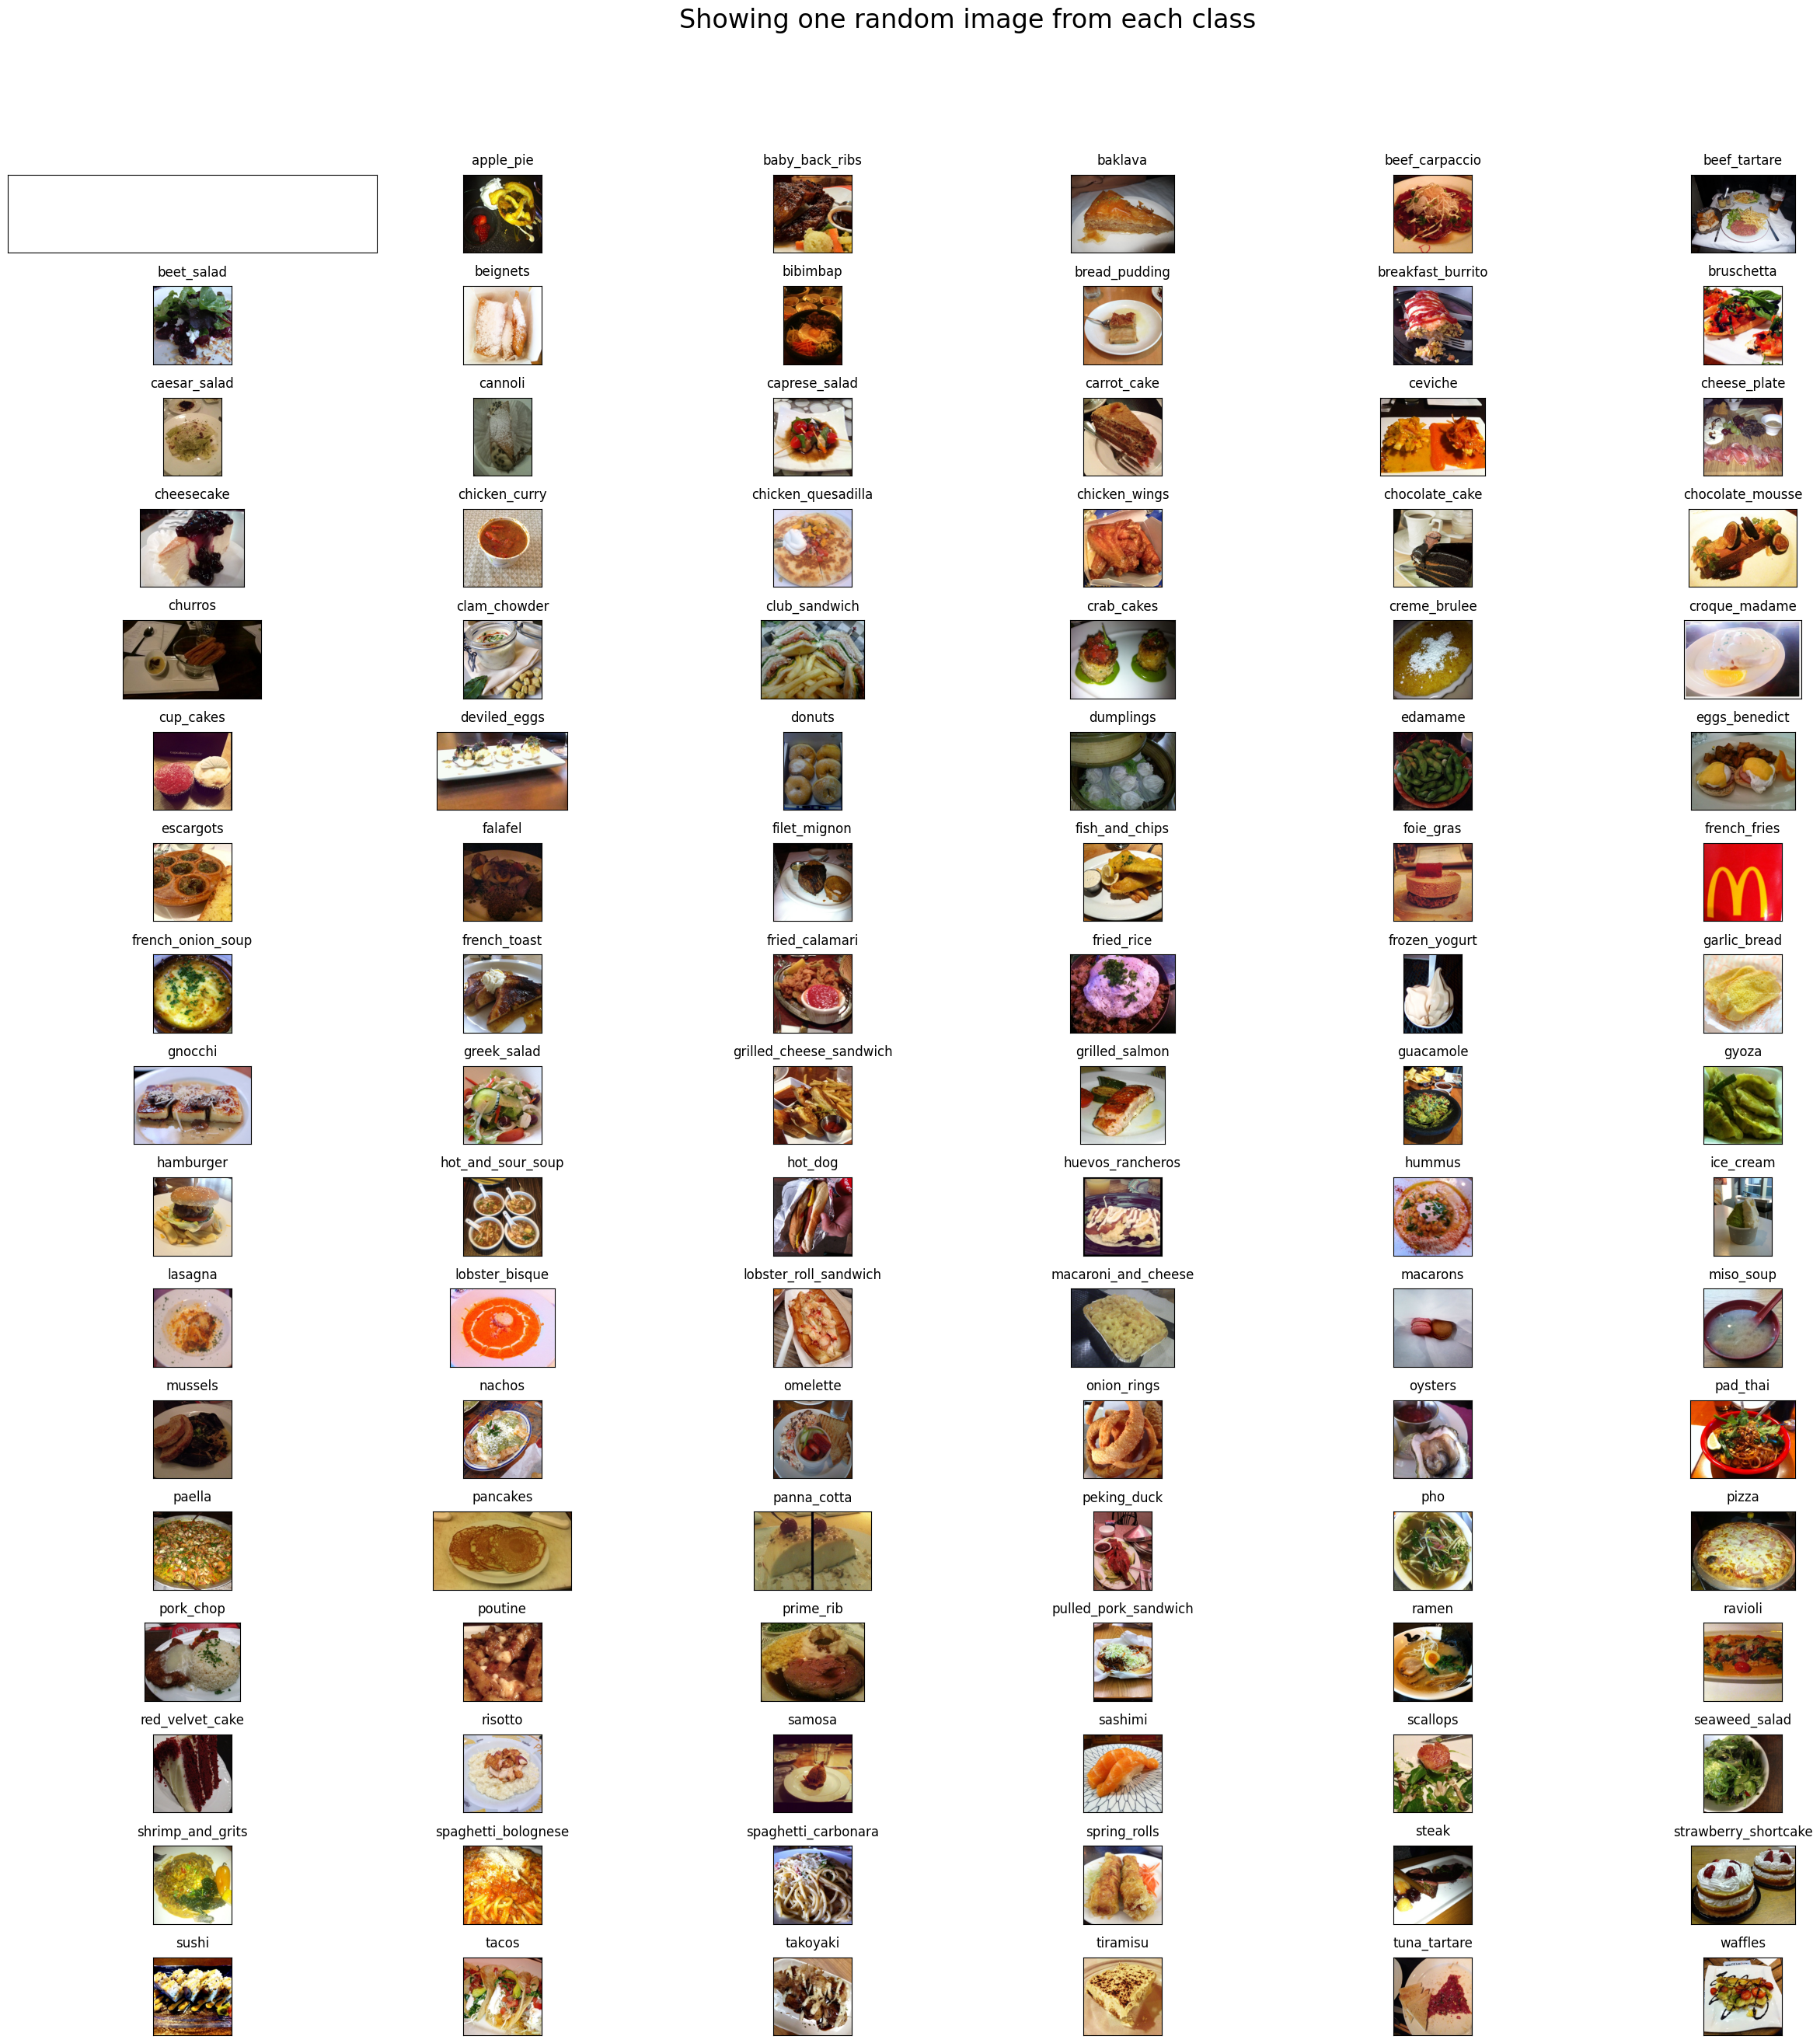

In [8]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [9]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [10]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('C:/Users/tanzi/OneDrive - Deakin University/Trimesters/Trimester 5/SIT782 - TEAM PROJECT (B) - EXECUTION AND DELIVERY/0.1 Project/food-101/food-101/food-101/meta/train.txt', 'C:/Users/tanzi/OneDrive - Deakin University/Trimesters/Trimester 5/SIT782 - TEAM PROJECT (B) - EXECUTION AND DELIVERY/0.1 Project/food-101/food-101/food-101/images', 'train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [11]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('C:/Users/tanzi/OneDrive - Deakin University/Trimesters/Trimester 5/SIT782 - TEAM PROJECT (B) - EXECUTION AND DELIVERY/0.1 Project/food-101/food-101/food-101/meta/test.txt', 'C:/Users/tanzi/OneDrive - Deakin University/Trimesters/Trimester 5/SIT782 - TEAM PROJECT (B) - EXECUTION AND DELIVERY/0.1 Project/food-101/food-101/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [12]:
# Path to the train folder
train_folder = 'train'

# Count the number of files in the train folder
file_count = sum([len(files) for r, d, files in os.walk(train_folder)])

print("Total number of samples in train folder:", file_count)

Total number of samples in train folder: 75750


In [13]:
# Path to the test folder
test_folder = 'test'

# Count the number of files in the test folder
file_count = sum([len(files) for r, d, files in os.walk(test_folder)])

print("Total number of samples in test folder:", file_count)

Total number of samples in test folder: 25250


In [14]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [15]:
# Helper function to select n random food classes
def pick_n_random_classes(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  return food_list

In [16]:
n = 101
food_list = ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles']
print("Food List\n", food_list)

Food List
 ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons'

In [17]:
n_classes = n
img_width, img_height = 299, 299
train_data_dir = 'train'
validation_data_dir = 'test'
nb_train_samples = 75750
nb_validation_samples = 25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('./history_class.log')

history_class = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained.hdf5')

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


c:\Users\tanzi\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\tanzi\AppData\Local\Temp\ipykernel_5960\3870084749.py:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_class = model.fit_generator(train_generator,


Epoch 1/30
4734/4734 [==============================] - ETA: 0s - loss: 4.8030 - accuracy: 0.0959
Epoch 1: val_loss improved from inf to 3.82589, saving model to best_model_class.hdf5
4734/4734 [==============================] - 1226s 256ms/step - loss: 4.8030 - accuracy: 0.0959 - val_loss: 3.8259 - val_accuracy: 0.3347
Epoch 2/30
4734/4734 [==============================] - ETA: 0s - loss: 3.5770 - accuracy: 0.3226
Epoch 2: val_loss improved from 3.82589 to 2.46625, saving model to best_model_class.hdf5
4734/4734 [==============================] - 812s 171ms/step - loss: 3.5770 - accuracy: 0.3226 - val_loss: 2.4662 - val_accuracy: 0.5479
Epoch 3/30
4734/4734 [==============================] - ETA: 0s - loss: 2.7978 - accuracy: 0.4598
Epoch 3: val_loss improved from 2.46625 to 1.90868, saving model to best_model_class.hdf5
4734/4734 [==============================] - 807s 170ms/step - loss: 2.7978 - accuracy: 0.4598 - val_loss: 1.9087 - val_accuracy: 0.6490
Epoch 4/30
4734/4734 [======

In [18]:
def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['accuracy'])  # Changed 'acc' to 'accuracy'
    plt.plot(history.history['val_accuracy'])  # Changed 'val_acc' to 'val_accuracy'
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()

def plot_loss(history, title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

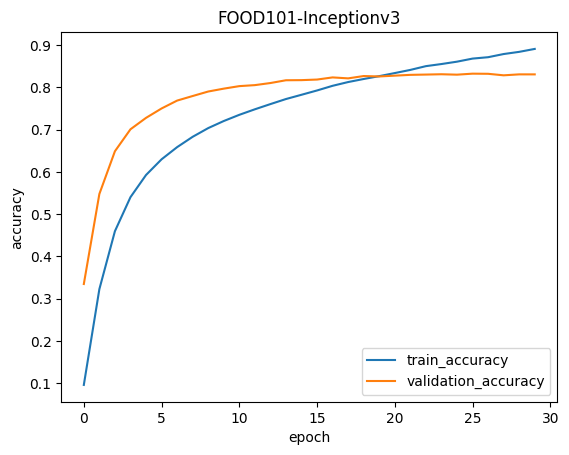

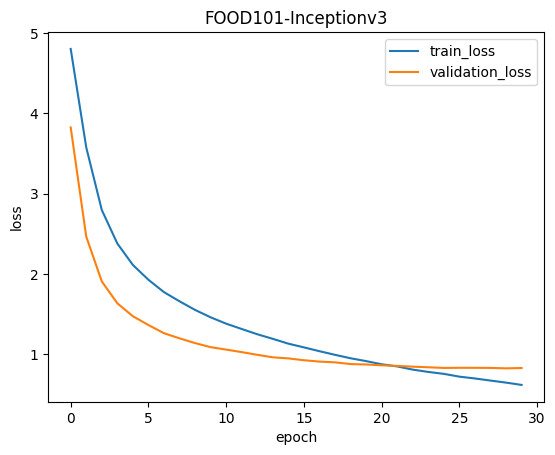

In [19]:
plot_accuracy(history_class, 'FOOD101-Inceptionv3')
plot_loss(history_class, 'FOOD101-Inceptionv3')